# Time series classification with sktime

The time series classification (TSC) task involves training a model from a collection
 of time series (real valued, ordered, data) in order to predict a target variable.
 For example, we might want to build a model that can predict whether a patient is
 sick based on the ECG reading, or predict whether a device will fail based on some
 sensor reading. This notebook gives a quick guide to get you started

## Data sets and problem types

The UCR/UEA [time series classification archive](https://timeseriesclassification.com/)
contains a large number of example TSC problems that have been used thousands of times
in the literature to assess TSC algorithms. These dataset have certain
characteristics that influence what data structure we use to store them in memory.

Most datasets in the archive contain time series all of the same length. For example, 
the [arrow
head dataset](https://timeseriesclassification.com/description.php?Dataset=ArrowHead) consists of outlines of the images of arrow heads. The
classification of projectile points is an important topic in anthropology.
<img src="./img/arrow-heads.png" width="400" alt="arrow heads">

The shapes of the projectile points are converted into a sequence using the
angle-based method as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html) about converting images into time series for data mining.

<img src="./img/from-shapes-to-time-series.png" width="400" alt="from shapes to time series">

Each instance consists of a single time series (i.e. the problem is univariate) of
equal length and a class label based on shape distinctions such as the presence and
location of a notch in the arrow. The data set consists of 210 instances, by
default split into 36 train and 175 test instances. We refer to the collection of
time series as $X$ and to the collection of class labels as $y$.

Below, we store the data in a 3D dimensional (instance, variable, time point) numpy array for $X$, and a one
dimensional (instance) numpy array for $y$.

For the single problem loader load arrow head, set the return type to `numpy3D` to store $X$ in such a 3D ndarray.
The data can also be returned in other formats, e.g., `pd-multiindex` (row-index hierarchical pandas), or `numpyflat` (2D numpy with rows=instances, columns=time points; alias is `numpy2d`). The full range of options are the `Panel` data format strings desribed in tutorial AA - datatypes and data loaders (see there).

In [1]:
# Imports used in this notebook
import matplotlib.pyplot as plt

from sktime.datasets import (
    load_arrow_head,
    load_basic_motions,
    load_japanese_vowels,
    load_plaid,
)

(36, 1, 251) (36,) (175, 1, 251) (175,)


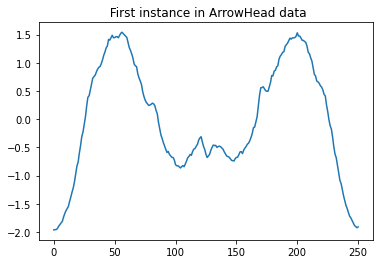

In [2]:
# Load all arrow head
arrow_X, arrow_y = load_arrow_head(return_type="numpy3d")
# Load default train/test splits from sktime/datasets/data
arrow_train_X, arrow_train_y = load_arrow_head(split="train", return_type="numpy3d")
arrow_test_X, arrow_test_y = load_arrow_head(split="test", return_type="numpy3d")
print(arrow_train_X.shape, arrow_train_y.shape, arrow_test_X.shape, arrow_test_y.shape)
plt.title(" First instance in ArrowHead data")
plt.plot(arrow_train_X[0, 0])

In [3]:
# Load arrow head dataset, pandas multiindex format, also accepted by sktime classifiers
arrow_train_X, arrow_train_y = load_arrow_head(
    split="train", return_type="pd-multiindex"
)
arrow_test_X, arrow_test_y = load_arrow_head(split="test", return_type="pd-multiindex")
print(arrow_train_X.head())

                         dim_0
instances timepoints          
0         0          -1.963009
          1          -1.957825
          2          -1.956145
          3          -1.938289
          4          -1.896657


In [4]:
# Load arrow head dataset in nested pandas format, also accepted by sktime classifiers
arrow_train_X, arrow_train_y = load_arrow_head(split="train", return_type="nested_univ")
arrow_test_X, arrow_test_y = load_arrow_head(split="test", return_type="nested_univ")
arrow_train_X.iloc[:5]

dim_0
0  0     -1.963009
1     -1.957825
2     -1.95614...
1  0     -1.774571
1     -1.774036
2     -1.77658...
2  0     -1.866021
1     -1.841991
2     -1.83502...
3  0     -2.073758
1     -2.073301
2     -2.04460...
4  0     -1.746255
1     -1.741263
2     -1.72274...

In [26]:
# Load arrow head dataset in numpy2d format, also accepted by sktime classifiers
arrow_train_X, arrow_train_y = load_arrow_head(split="train", return_type="numpy2d")
arrow_test_X, arrow_test_y = load_arrow_head(split="test", return_type="numpy2d")
print(arrow_train_X.shape, arrow_train_y.shape, arrow_test_X.shape, arrow_test_y.shape)

# CAUTION:
# while classifiers will interpret 2D numpy arrays as (instance, timepoint),
#   and as a collection/panel of univariate time series
# all other sktime estimator interpret 2D numpy arrays as (timepoint, variable),
#   i.e., a single, multivariate time series
#
# the reason for this ambiguity is ensuring sklearn compatibility
#   in classification, numpy 2D is typically passed as (instance, timepoint) to sklearn
#   in forecasting, numpy 2D is typically passed as (timepoint, variable) to sklearn

(36, 251) (36,) (175, 251) (175,)


Some TSC datasets are multivariate, in that each time series instance has more than one
variable. For example, the data [basic motions dataset]
(https://timeseriesclassification.com/description.php?Dataset=BasicMotions)
 was generated as part of a student project where four students performed
four activities whilst wearing a smart watch. The watch collects 3D accelerometer and
 a 3D gyroscope. Each instance involved a subject performing one of four tasks (walking,
 resting, running and badminton) for ten seconds. Time series in this data set have 6 variables.

<class 'numpy.ndarray'>
(40, 6, 100) (40,) (40, 6, 100) (40,)


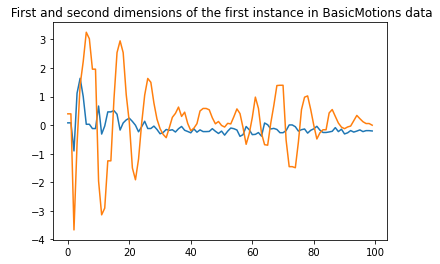

In [5]:
# "basic motions" dataset
motions_X, motions_Y = load_basic_motions(return_type="numpy3d")
motions_train_X, motions_train_y = load_basic_motions(
    split="train", return_type="numpy3d"
)
motions_test_X, motions_test_y = load_basic_motions(split="test", return_type="numpy3d")
print(type(motions_train_X))
print(
    motions_train_X.shape,
    motions_train_y.shape,
    motions_test_X.shape,
    motions_test_y.shape,
)
plt.title(" First and second dimensions of the first instance in BasicMotions data")
plt.plot(motions_train_X[0][0])
plt.plot(motions_train_X[0][1])

Some data sets have unequal length series. Two data sets with this characteristic
are shipped with sktime: PLAID (univariate) and JapaneseVowels (multivariate). We
cannot store unequal length series in numpy arrays. Instead, we use nested pandas
data frames, where each cell is a pandas Series. This is the default return type for 
all single problem loaders.

<class 'pandas.core.frame.DataFrame'>


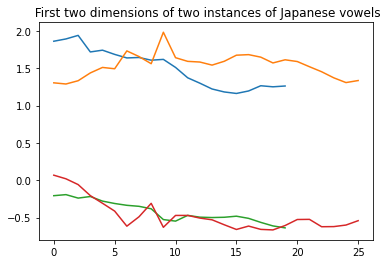

In [6]:
# loads both train and test together
vowel_X, vowel_y = load_japanese_vowels()
print(type(vowel_X))

plt.title(" First two dimensions of two instances of Japanese vowels")
plt.plot(vowel_X.iloc[0, 0])
plt.plot(vowel_X.iloc[1, 0])
plt.plot(vowel_X.iloc[0, 1])
plt.plot(vowel_X.iloc[1, 1])
plt.show()

<class 'pandas.core.frame.DataFrame'>


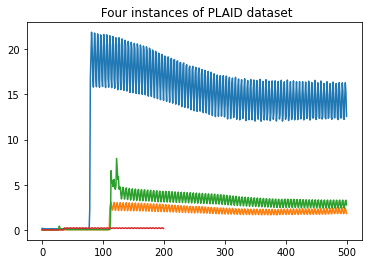

In [7]:
plaid_X, plaid_y = load_plaid()
print(type(plaid_X))

plt.title(" Four instances of PLAID dataset")
plt.plot(plaid_X.iloc[0, 0])
plt.plot(plaid_X.iloc[1, 0])
plt.plot(plaid_X.iloc[2, 0])
plt.plot(plaid_X.iloc[3, 0])
plt.show()

## Building Classifiers

We demonstrate the simplest use cases for classifiers and demonstrate how to build bespoke pipelines for time series classification.

It is possible to use a standard `sklearn` classifier for univariate, equal length classification problems but it is unlikely to
perform as well as bespoke time series classifiers, since supervised tabular classifiers ignore the sequence information in the variables.

To apply `sklearn` classifiers directly, the data needs to be reshaped into one of the sklearn compatible 2D data formats. 
`sklearn` cannot be used directly with multivariate or unequal length data sets, without making choices in how to insert the data into a 2D structure.

`sktime` provides functionality to make these choices explicit and tunable, under a unified interface for time series classifiers.

`sktime` also provides pipeline construction functionality for transformers and classifiers that are specific to time series datasets.

Direct application of `sklearn` (without `sktime`) is possible via using the `numpy2d` return type for the time series data sets, and then feeding the format into `sklearn`:

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(n_estimators=100)
arrow_train_X_2d, arrow_train_y_2d = load_arrow_head(
    split="train", return_type="numpy2d"
)
arrow_test_X_2d, arrow_test_y_2d = load_arrow_head(split="test", return_type="numpy2d")
classifier.fit(arrow_train_X_2d, arrow_train_y_2d)
y_pred = classifier.predict(arrow_test_X_2d)
accuracy_score(arrow_test_y_2d, y_pred)

0.68

`sktime` contains the state of the art in time series classifiers in the package
classification. These are grouped based on their representation. An accurate and
relatively fast classifier is called [ROCKET](https://arxiv.org/abs/1910.13051)

In [10]:
from sktime.classification.kernel_based import RocketClassifier

rocket = RocketClassifier()
rocket.fit(arrow_train_X, arrow_train_y)
y_pred = rocket.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

0.8171428571428572

A state-of-art algorithm for time series classification is version 2 of the [HIVE-COTE algorithm](https://link.springer.com/article/10.1007/s10994-021-06057-9). HC2 is slow on small
problems like these examples. However, it can be configured with an approximate
maximum run time as follows (may take a bit longer than a minute to run this cell).

In [11]:
from sktime.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2(time_limit_in_minutes=1)
hc2.fit(arrow_train_X, arrow_train_y)
y_pred = hc2.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

0.8514285714285714

Most classifiers in `sktime` involve some degree of transformation. The simplest form
is simply consisting of a pipeline of transformation (aka "feature extraction") followed by an `sklearn` classifier.

The `sktime` `make_pipeline` utility allows to combine transformers and classifiers into a simple pipeline.
The classifier pipelined can be an `sktime` time series classifier, or an `sklearn` tabular classifier.
If an `sklearn` classifier, the time series are formatted as (instance, time index) formatted 2D array before being passed to the `sklearn` classifier.

In the following example, we use the [tsfresh](https://tsfresh.readthedocs.io/en/latest/) feature extractor to
extract features which are then used in a (tabular, `sklearn`) random forest classifier.
This can be done with the `sktime`'s `make_pipeline` utility as follows:

In [12]:
from sklearn.ensemble import RandomForestClassifier

from sktime.pipeline import make_pipeline
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

tsfresh_trafo = TSFreshFeatureExtractor(default_fc_parameters="minimal")
randf = RandomForestClassifier(n_estimators=100)
pipe = make_pipeline(tsfresh_trafo, randf)

pipe.fit(arrow_train_X, arrow_train_y)
y_pred = pipe.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

Feature Extraction: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


0.6457142857142857

In the following example, we pipeline an `sktime` transformer with an `sktime` time series classifier:

In [20]:
from sktime.classification.kernel_based import RocketClassifier
from sktime.pipeline import make_pipeline
from sktime.transformations.series.exponent import ExponentTransformer

square = ExponentTransformer(power=2)
rocket = RocketClassifier()
pipe_sktime = square * rocket

Under the hood, `sktime`'s `make_pipeline` utiltiy dispatches to right pipeline class that exposes different kinds of pipeline under the familiar `sktime` time series classification interface. In the above examples, these were `SklearnClassifierPipeline` (for `sklearn` classifiers at the end) and `ClassifierPipeline` (for `sktime` classifiers at the end):

In [18]:
pipe

ClassifierPipeline(classifier=RocketClassifier(),
                   transformers=[ExponentTransformer(power=2)])

In [21]:
pipe_sktime

ClassifierPipeline(classifier=RocketClassifier(),
                   transformers=[ExponentTransformer(power=2)])

Alternatively, the pipelines could have been constructed directly with the special pipeline classes for more granular control, see docstrings of the aforementioned classes for further options.

Pipelines can also be defined, even more concisely, by using the `*` dunder operator, which is a shorthand for `make_pipeline`. Estimators on the right are pipelined after estimators on the left of the operator.

In [13]:
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.series.exponent import ExponentTransformer

square = ExponentTransformer(power=2)
rocket = RocketClassifier()
pipe = square * rocket
pipe

ClassifierPipeline(classifier=RocketClassifier(),
                   transformers=[ExponentTransformer(power=2)])

In [14]:
pipe.fit(arrow_train_X, arrow_train_y)
y_pred = pipe.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

0.8228571428571428

Using `sktime` pipeline constructs is encouraged above using `sklearn` `Pipeline`, as `sktime` pipelines will come with base class features such as input checks, input data format compatibility, and tag handling. However, `sktime` estimators are, in general, also compatible with `sklearn` pipelining use cases, as long as the `sklearn` adjacent data formats are being used, namely `numpy3D` or `nested_univ`. Conversely, `sklearn` native compositor elements will in general not be compatible with use of row hierarchical data formats such as `pd-multiindex`, and will not automatically convert, or provide `sktime` compatible tag inspection functionality.

## Multivariate classification
Many classifiers, including ROCKET and HC2, are configured to work with multivariate
input. For example

In [15]:
rocket.fit(motions_train_X, motions_train_y)
y_pred = rocket.predict(motions_test_X)
accuracy_score(motions_test_y, y_pred)
hc2.fit(motions_train_X, motions_train_y)
y_pred = hc2.predict(motions_test_X)
accuracy_score(motions_test_y, y_pred)

1.0

sktime offers two other ways of solving multivariate time series classification 
problems:

1. Concatenation of time series columns into a single long time series column via 
`ColumnConcatenator` and apply a classifier to the concatenated data,
2. Dimension ensembling via `ColumnEnsembleClassifier` in which one classifier is
 fitted for each time series column/dimension of the time series and their predictions 
 are combined through a voting scheme. 

We can concatenate multivariate time series/panel data into long univariate time 
series/panel using a tran and then apply a classifier to the univariate data.


In [16]:
from sktime.classification.interval_based import DrCIF
from sktime.transformations.panel.compose import ColumnConcatenator

clf = ColumnConcatenator() * DrCIF(n_estimators=10)
clf.fit(motions_train_X, motions_train_y)
clf.score(motions_test_X, motions_test_y)

0.975

We can also fit one classifier for each time series column and then aggregated their 
predictions. The interface is similar to the familiar `ColumnTransformer` from sklearn.

In [17]:
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import TemporalDictionaryEnsemble
from sktime.classification.interval_based import DrCIF

clf = ColumnEnsembleClassifier(
    estimators=[
        ("DrCIF0", DrCIF(n_estimators=10), [0]),
        ("TDE3", TemporalDictionaryEnsemble(max_ensemble_size=5), [3]),
    ]
)

clf.fit(motions_train_X, motions_train_y)
clf.score(motions_test_X, motions_test_y)

0.975

### Background info and references for classifiers used here

#### The RocketClassifier 
is based on a pipeline combination of the ROCKET transformation (transformations
.panel.rocket) and the sklearn RidgeClassifierCV classifier. The RocketClassifier is 
configurable to use variants minirocket and multirocket. ROCKET is based on 
generating random convolutions. A large number are generated then the classifier 
performs a feature selection.

[1] Dempster, Angus, François Petitjean, and Geoffrey I. Webb. "Rocket:
       exceptionally fast and accurate time series classification using random
       convolutional kernels." Data Mining and Knowledge Discovery 34.5 (2020)
[arXiv version](https://arxiv.org/abs/1910.13051)

#### DrCIF
The Diverse Representation Canonical Interval Forest Classifier (DrCIF) is an 
interval based classifier. The algorithm takes multiple randomised intervals from 
each series and extracts a range of features. These features are used to build a 
decision tree, which in turn are ensembled into a decision forest, in the style of a 
random forest. The original version 

[2] Matthew Middlehurst and James Large and Anthony Bagnall. "The Canonical
       Interval Forest (CIF) Classifier for Time Series Classification."
       IEEE International Conference on Big Data 2020
[arXiv version](https://arxiv.org/abs/2008.09172)

The DrCIF adjustment was proposed in [4]        
#### TDE
he Temporal Dictionary Ensemble is a dictionary based classifier. The basic premise 
is to extract discrete patterns using a windowing and to count their occurence. 
Classification is based on these frequency histograms. TDE includes bigram 
frequencies, spatial pyramids and a Gaussian process based parameter search. 

[3] Matthew Middlehurst, James Large, Gavin Cawley and Anthony Bagnall
        "The Temporal Dictionary Ensemble (TDE) Classifier for Time Series
        Classification", in proceedings of the European Conference on Machine Learning
        and Principles and Practice of Knowledge Discovery in Databases, 2020.
[arXiv version](https://arxiv.org/abs/2105.03841)

#### HiveCoteV2 (HC2)

The HIerarchical VotE Collective of Transformation-based Ensembles is a meta ensemble
 that combines classifiers built on different representations. Version 2 
 combines DrCIF, TDE, an ensemble of RocketClassifiers called the Arsenal and the 
 ShapeletTransformClassifier. It is currently the most accurate classifier on the UCR
  and UEA time series archives. 
   
[4] Middlehurst, Matthew, James Large, Michael Flynn, Jason Lines, Aaron Bostrom,
       and Anthony Bagnall. "HIVE-COTE 2.0: a new meta ensemble for time series
       classification." [Machine Learning (2021)](https://link.springer.com/article/10.1007/s10994-021-06057-9)